In [29]:

import plotly.graph_objects as go
import magpylib as magpy
from scipy.spatial.transform import Rotation as R
import magpylib as magpy
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.signal import butter, lfilter, freqz, detrend
import matplotlib.pyplot as plt
import scipy.fftpack
import numpy as np

from field_calc import *
from util import *

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

fs = 1/0.01      # sample rate, Hz

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [30]:
# Load data
t_punching, b_punching = load_data('data/punching.csv')
t_slide, b_slide = load_data_sensor('data/slide_10_50.csv')


Min:  1.0013580322265625e-05
Max:  0.20477294921875
Average:  0.004601303534616522
Standard Deviation:  0.02181290033804207
Delta: 0.20476293563842773


Sampling frequency:  217.32971808462557


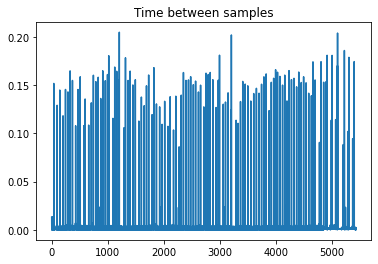

In [31]:
# Calculate sampling frequency
def calc_fs(timestamps):
    tdiff = []
    for i in range(1, len(timestamps)):
        tdiff.append(float(timestamps[i]) - float(timestamps[i-1]))
    calc_signal_stats(tdiff)
    fs = 1/np.mean(tdiff) 
    plt.plot(tdiff)
    plt.title("Time between samples")
    print('Sampling frequency: ', fs)
    return fs
fs = calc_fs(t_slide)

Min:  109.23085467696094
Max:  110.72112910072036
Average:  109.81066881862469
Standard Deviation:  0.3966185122117073
Delta: 1.4902744237594163




/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



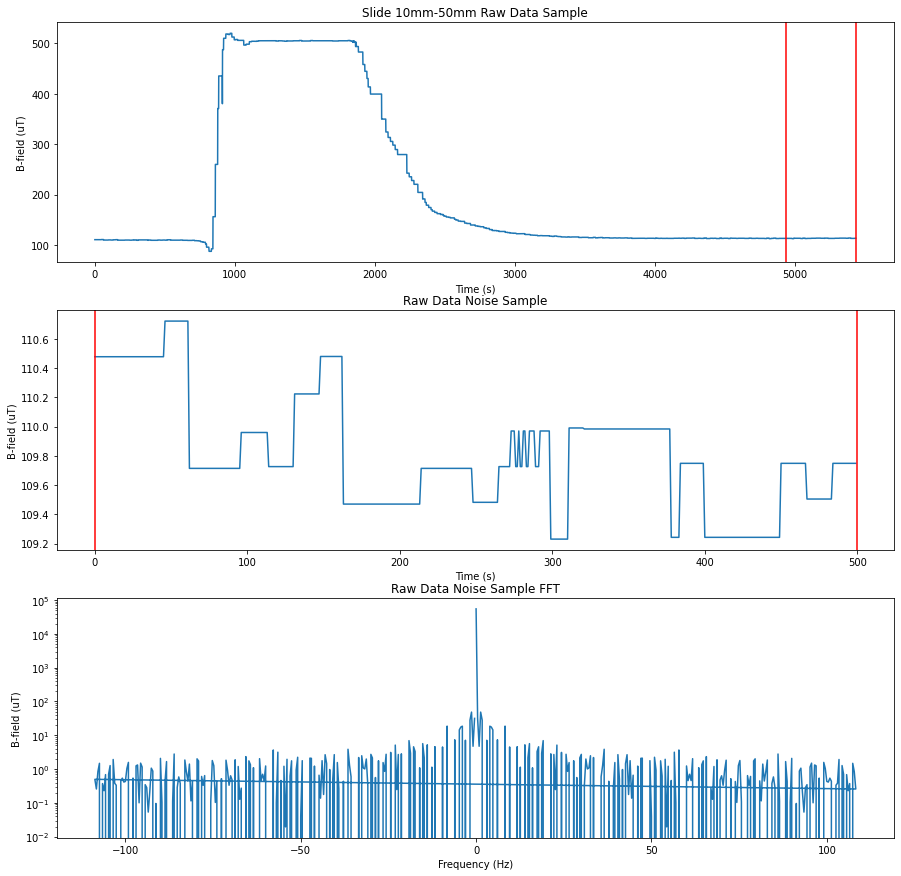

In [32]:
# CALCULATE NOISE
t_noise = t_slide
b_noise = b_slide
num_samples = 500
t_noise = t_noise[:num_samples]
b_noise = b_noise[:num_samples]
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(3)

signal_ax = ax[0]
noise_ax = ax[1]
noise_fft_ax = ax[2]

b_noise_fft = np.fft.fft(b_noise)
b_noise_freq = np.fft.fftfreq(len(b_noise), 1/fs)
b_noise_fft_inv = np.fft.ifft(b_noise_fft)

signal_ax.plot(b_slide)
signal_ax.set_xlabel("Time (s)")
signal_ax.set_ylabel("B-field (uT)")
signal_ax.set_title("Slide 10mm-50mm Raw Data Sample")
signal_ax.axvline(x=len(b_slide)-500, color='r')
signal_ax.axvline(x=len(b_slide), color='r')

noise_ax.plot(b_noise)
noise_ax.set_xlabel("Time (s)")
noise_ax.set_ylabel("B-field (uT)")
noise_ax.set_title("Raw Data Noise Sample")
noise_ax.axvline(x=0, color='r')
noise_ax.axvline(x=len(b_noise), color='r')

noise_fft_ax.semilogy(b_noise_freq, b_noise_fft)
noise_fft_ax.set_xlabel("Frequency (Hz)")
noise_fft_ax.set_ylabel("B-field (uT)")
noise_fft_ax.set_title("Raw Data Noise Sample FFT")

noise_avg = np.average(b_noise)
noise_std = np.std(b_noise)
noise_delta = np.max(b_noise) - np.min(b_noise)
calc_signal_stats(b_noise)

b_slide = b_slide - noise_avg

In [33]:
# DEFINE MAGNET
max_reading = 800 # uT max reading from magnetometer
# n52_magnetization = 1420 # mT
n52_magnetization = 800 # mT

# Define a magnet matching the sensor readings
magnet = magpy.magnet.Cuboid(
    magnetization=(0,0, n52_magnetization),
    dimension=(40,10,8),
    position=(0,0,0),
)

sens = magpy.Sensor(
    position=(0,0,0),
    pixel=[(0,0,0)],
    style_pixel_size=0.5,
    style_size=1.5,
)

print(calc_b_field(magnet, sens, 100))
print(calc_b_field(magnet, sens, 300))


392.0524792655075
15.024649165335644


In [34]:
# FIND CALIBRATION DISTANCE

def calc_calibration_distance(max_b_reading):
    """
    Calculate the distance at which the magnetometer reads the maximum value.
    """
    def f(d):
        err = abs(max_b_reading - calc_b_field(magnet, sens, d))
        return err
    r = root(f, 50, tol=0.01)
    # print(r)
    return r.x[0]

calibration_distance = calc_calibration_distance(max_reading)
print("Calibration distance: %d mm" % calibration_distance)

# FIND MAX DISTANCE
def calc_max_distance(max_error):
    """
    Calculate the max distance which can be used given the maximum distance error acceptable.
    """
    def f(d):
        err = max_error - abs(d - calc_displacement(magnet, sens, calc_b_field(magnet, sens, d) + 3*noise_std))
        return err
    r = root(f, 0, tol=0.01)
    # print(r)
    return abs(r.x[0])

max_distance = calc_max_distance(50)
print("Accepted Error %d mm Max distance: %d mm" % (100, max_distance))


Calibration distance: 78 mm
Accepted Error 100 mm Max distance: 494 mm


(0.0, 494.5168626878299)

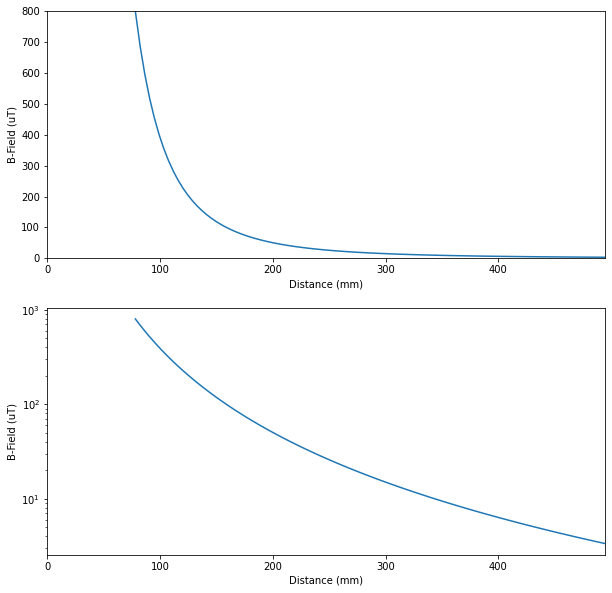

In [35]:
# Calc B-field for each distance
# Test at 5cm - 50cm
d = np.linspace(calibration_distance, max_distance, 100)
B = [calc_b_field(magnet, sens, distance) for distance in d]

fig = plt.figure(figsize=(10, 10))
ax = fig.subplots(2)
ax[0].plot(d, B)
ax[0].set_ylabel("B-Field (uT)")
ax[0].set_xlabel("Distance (mm)")
ax[0].set_xlim(0, max_distance)
ax[0].set_ylim(0, max_reading)
ax[1].semilogy(d, B)
ax[1].set_ylabel("B-Field (uT)")
ax[1].set_xlabel("Distance (mm)")
ax[1].set_xlim(0, max_distance)


In [36]:
# ## 3D SIMULATE
# print(calcBField(50)*1000)
# print(calcDisplacement(1))

# # shaft rotation / magnet wobble motion
# displacement = 1
# angles = np.linspace(0, 360, 72)
# coll = magnet
# magnet.move((displacement, 0, 0))
# coll.rotate_from_angax(angles, 'z', anchor=0, start=0)

# # show 3D animation of wobble motion
# fig1 = go.Figure()
# magpy.show(magnet, sens, animation=True, backend='plotly', canvas=fig1)
# fig1.update_layout(scene_camera_eye_z=-1.1)
# fig1.show()

# # show sensor output in plotly
# fig2 = go.Figure()
# B = sens.getB(magnet)
# for px,dash in zip([0,1], ['solid', 'dash']):
#     for i,xy,col in zip([0,1], ['x','y'], ['red', 'green']):
#         fig2.add_trace(go.Scatter(x=angles, y=B[:,px,i],
#             name=f"pixel{px}-B{xy}",
#             line=dict(color=col, dash=dash),
#         ))
# fig2.update_layout(
#     xaxis_title='angle [deg]',
#     yaxis_title='field [mT]'
# )
# fig2.show()



In [37]:
# disp = np.linspace((0,0,0), (0, 0, 33.33), 101)
# magnet.move(disp, start=-1)

# fig1 = go.Figure()
# magpy.show(magnet, sens, animation=True, backend='plotly', canvas=fig1)
# fig1.show()



# B = sens.getB(magnet)

# b_mag = [np.linalg.norm(B_coord) for B_coord in B]
# disp_mag = [int(np.linalg.norm(d)) for d in disp] 
# fig = plt.figure()
# ax = fig.subplots()
# ax.plot(disp_mag, b_mag, "r")
# ax.set_xlabel("displacement (mm)")
# ax.set_ylabel("Field (uT)")



Text(0, 0.5, 'Displacement Error (mm)')

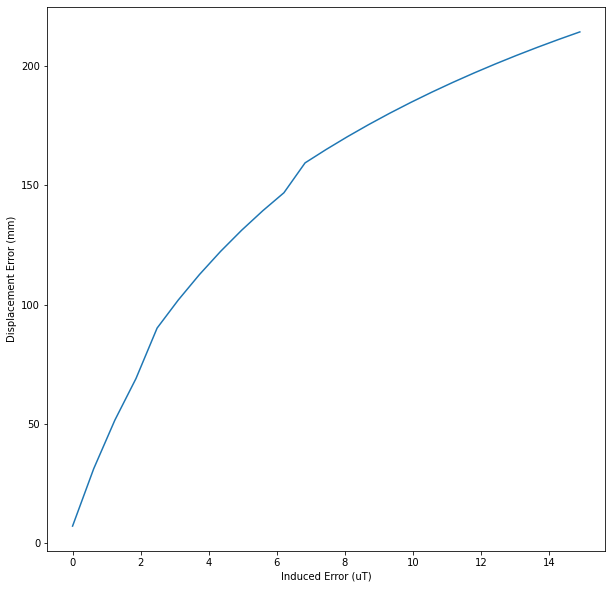

In [38]:
# ESTIME ERROR AT DISTANCE
@np.vectorize
def calc_error(reading_distance, induced_error):
    b_true = abs(calc_b_field(magnet, sens, reading_distance))
    d_true = abs(reading_distance)

    err = d_true - abs(calc_displacement(magnet, sens, b_true + induced_error))
    err = np.abs(err)
    return err

induced_error = np.linspace(0, 10*noise_delta, 25) # Error range from 0 to 2uT
reading_distance = np.linspace(calibration_distance, max_distance, 10)
X, Y = np.meshgrid(reading_distance, induced_error)
Z = calc_error(X, Y)

err = calc_error(max_distance, induced_error)
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
ax.plot(induced_error, err)
ax.set_xlabel("Induced Error (uT)")
ax.set_ylabel("Displacement Error (mm)")

Text(0, 0.5, 'Displacement Error (mm)')

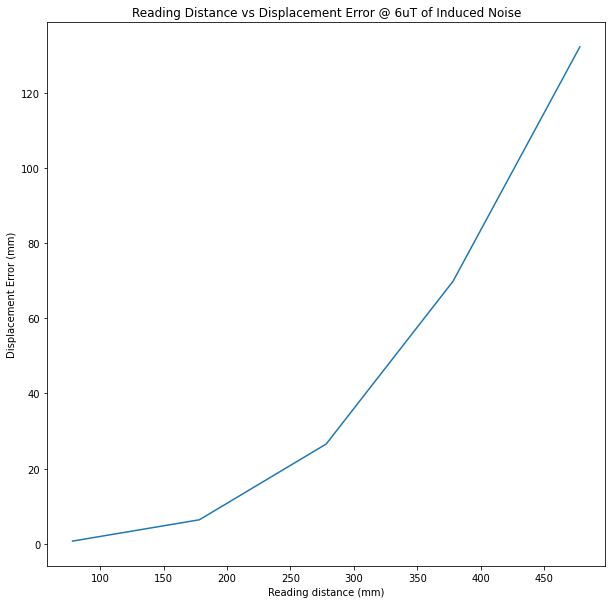

In [39]:
distance = np.arange(calibration_distance, max_distance, 100)
err = calc_error(distance, 6)
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
ax.plot(distance, err)
ax.set_title("Reading Distance vs Displacement Error @ 6uT of Induced Noise")
ax.set_xlabel("Reading distance (mm)")
ax.set_ylabel("Displacement Error (mm)")

In [40]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])

fig.update_layout(title='Error', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()
calc_error(11, 486)


array(0.02904522)

In [42]:
b_slide_trunc = b_slide[1000:]
disp = calc_displacement(magnet, sens, b_slide_trunc)
disp = np.abs(disp)

In [43]:
num_avg_samples = 10
disp_avg = np.convolve(disp, np.ones((num_avg_samples,))/num_avg_samples, mode='valid')

In [44]:
print(disp[0])
print(disp[-1])
print(len(disp))

98.30657890511088
483.6580340002966
4437


289.6618171164275
3.4508286557260135


array(110.29824266)

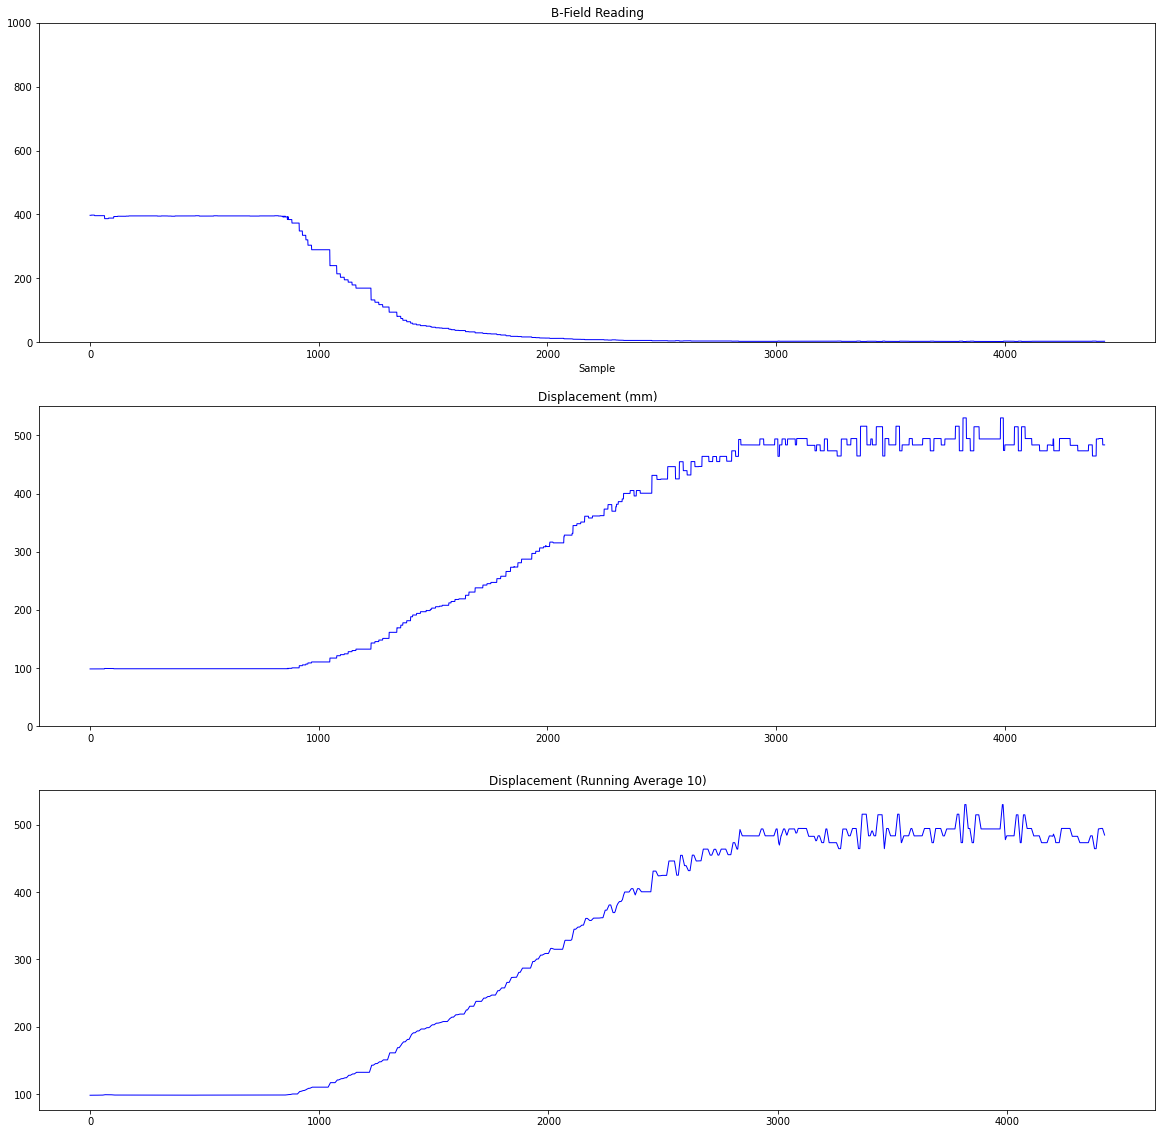

In [45]:
### Slide 10-50
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(3)
b_reading_ax = ax[0]
disp_avg_ax = ax[2]
disp_ax = ax[1]

b_reading_ax.set_title("B-Field Reading")
b_reading_ax.set_ylim(0, 1000)
b_reading_ax.set_xlabel('Sample')
disp_avg_ax.set_title("Displacement (Running Average %s)" % num_avg_samples)
disp_ax.set_title("Displacement (mm)")
disp_ax.set_ylim(0, 550)

t = np.arange(0, len(b_slide_trunc), 1)

b_reading_ax.plot(t, b_slide_trunc, 'b-', linewidth=1, label='data')
disp_ax.plot(t, disp, 'b-', linewidth=1, label='data')

disp_avg_ax.plot(np.arange(0, len(disp_avg), 1), disp_avg, 'b-', linewidth=1, label='data')
print(b_slide_trunc[1000])
print(b_slide_trunc[-1])

calc_displacement(magnet, sens, b_slide_trunc[1000])


Min:  2.6981018627177207
Max:  3.9637230283600786
Average:  3.3631650125987633
Standard Deviation:  0.2739230048436344
Delta: 1.265621165642358


Min:  464.0134134498743
Max:  530.0638150426945
Average:  488.93906841655865
Standard Deviation:  13.853614735479214
Delta: 66.05040159282021


Min:  464.5476036103138
Max:  514.8344703388132
Average:  485.06899821271185
Standard Deviation:  10.798967522386942
Delta: 50.286866728499376




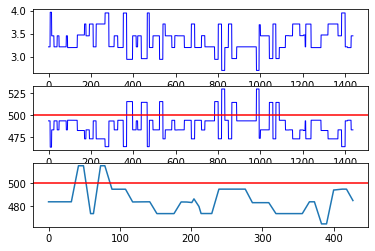

In [46]:
## Check noise at large distances
b = b_slide[4000:]
t = np.arange(0, len(b), 1)
fix, ax = plt.subplots(3)
b_ax = ax[0]
d_ax = ax[1]
d_avg_ax = ax[2]
b_ax.plot(t, b, 'b-', linewidth=1, label='data')
calc_signal_stats(b)
d = calc_displacement(magnet, sens, b)
d = np.abs(d)
d_ax.plot(t, d, 'b-', linewidth=1, label='data')
d_ax.axhline(500, color='r')

d_avg_ax.plot(np.arange(0, len(disp_avg[4000:]), 1), disp_avg[4000:])
d_avg_ax.axhline(500, color='r')

calc_signal_stats(d)
calc_signal_stats(disp_avg[4000:])

In [47]:
data = b_raw
disp_zero = calc_displacement(magnet, sens, noise_avg)
data_filtered = np.abs(calc_displacement(magnet, sens, data)) - disp_zero


NameError: name 'b_raw' is not defined

(251.60711938533362, 413.28114357712104)

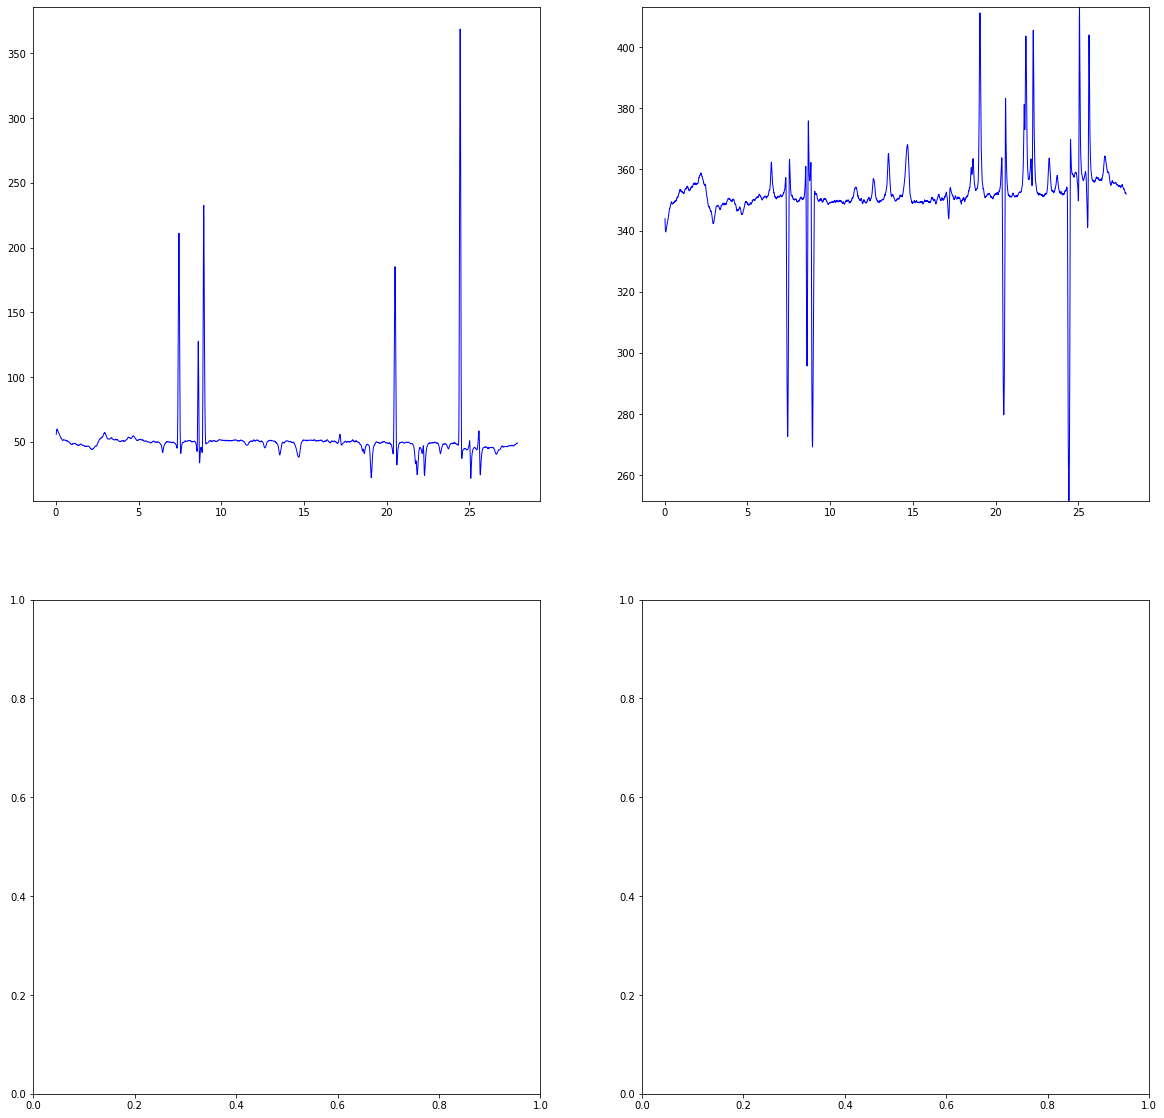

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 2)
ax[0][0].plot(t_raw, data, 'b-', linewidth=1, label='data')
ax[0][1].plot(t_raw, data_filtered, 'b-', linewidth=1, label='data')
ax[0][1].set_ylim(data_filtered.min(), data_filtered.max())
